<a href="https://colab.research.google.com/github/areegtarek/Transistor-Current-Prediction-Model/blob/main/Transistor_Current_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transistor Current Prediction Model**

This project aims to build a machine-learning model for predicting a transistor's drain current (Id) based on its parameters and operating conditions.

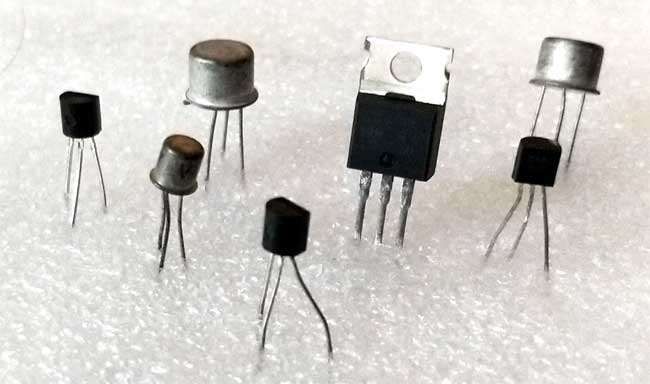

A transistor's Id depends non-linearly on factors like gate-source voltage (Vgs), drain-source voltage (Vds), temperature, and device dimensions. This work develops a neural network model to learn these complex relationships from simulated transistor data.

The goal is to provide a tool that can estimate Id given new combinations of inputs, without relying on complex physical simulations. The trained model could then be deployed for circuit simulation or transistor-level defect analysis tasks.

# **Data Description**

**The data columns:**

**vds** - Drain-source voltage (V)

This is the voltage applied between the drain and source terminals of the transistor. It varies the operating region between cut-off, linear, and saturation modes.

**L(um)** - Channel length (μm)

The physical length of the transistor channel. Shorter lengths introduce additional short-channel effects.

**W(um)** - Channel width (μm)

Wider transistors allow higher currents but also increase parasitic capacitances. The W/L ratio impacts current.

**drain_length(um)** - Drain extension length (μm)

The diffused drain contact region introduces parasitic resistance and capacitance. Longer extensions increase these effects.

**temperature** - Operating temperature (°C)

Higher temperatures reduce carrier mobility and affect threshold voltages through physics mechanisms. Must account for temperature variations.

**vgs** - Gate-source voltage (V)

Controls whether the transistor is on or off. Vgs must exceed the threshold voltage Vt to form an inversion layer channel.

**vsb** - Source-bulk voltage (V)

Applying a positive vsb lowers the threshold voltage Vt, making it easier to turn on the transistor.

**corner** - Process corner

Categorical variables (tt, ff, ss, sf) indicate how device parameters vary from typical conditions due to process variations.

**id(uA)** - Drain current (μA)

The output current passes through the transistor channel from the drain to the source. Strongly depends on the input signal and bias conditions through complex nonlinear relationships.

# **Importing the libraries and the dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization
from tensorflow.keras import backend as K

#Set Matplotlib options
%matplotlib inline
plt.style.use('ggplot')
sns.set_style("whitegrid")

#Increase max Pandas columns
pd.set_option('display.max_columns', 200)

#Define color palette
my_palette = sns.color_palette("Paired", 2)

import pandas as pd
import warnings
from scipy import stats

# ignore FutureWarning
warnings.simplefilter(action = 'ignore')

# **Data Exploration**

In [3]:
dataset= pd.read_csv('/content/drive/MyDrive/Mabrains Transistors/simulated_data_nmos.csv')

In [4]:
df=dataset[['vds', 'L(um)', 'W(um)', 'drain_length(um)', 'temperature', 'vgs',
            'vsb', 'corner', 'id(uA)']]

In [5]:
df.head()

,vds,L(um),W(um),drain_length(um),temperature,vgs,vsb,corner,id(uA)
0,-0.45,8.0,0.84,0.3,27.0,0.0,0.0,tt,0.034866
1,-0.40,8.0,0.84,0.3,27.0,0.0,0.0,tt,0.009451
2,-0.35,8.0,0.84,0.3,27.0,0.0,0.0,tt,0.002331
3,-0.30,8.0,0.84,0.3,27.0,0.0,0.0,tt,0.000532
4,-0.25,8.0,0.84,0.3,27.0,0.0,0.0,tt,0.000111


In [6]:
df.shape

(871488, 9)

In [7]:
df.columns

Index(['vds', 'L(um)', 'W(um)', 'drain_length(um)', 'temperature', 'vgs',
       'vsb', 'corner', 'id(uA)'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871488 entries, 0 to 871487
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   vds               871488 non-null  float64
 1   L(um)             871488 non-null  float64
 2   W(um)             871488 non-null  float64
 3   drain_length(um)  871488 non-null  float64
 4   temperature       871488 non-null  float64
 5   vgs               871488 non-null  float64
 6   vsb               871488 non-null  float64
 7   corner            871488 non-null  object 
 8   id(uA)            871488 non-null  float64
dtypes: float64(8), object(1)
memory usage: 59.8+ MB


In [9]:
# statistical summary
df.describe()

,vds,L(um),W(um),drain_length(um),temperature,vgs,vsb,id(uA)
count,871488.000000,871488.000000,871488.000000,8.714880e+05,871488.0,871488.000000,871488.000000,871488.000000
mean,1.000138,0.329525,3.664366,3.000000e-01,27.0,0.895708,0.745869,339.674855
std,0.880264,0.431887,6.682675,4.996006e-16,0.0,0.535547,0.513941,1229.868653
min,-0.500000,0.150000,0.360000,3.000000e-01,27.0,0.000000,0.000000,0.000000
25%,0.250000,0.150000,0.650000,3.000000e-01,27.0,0.450000,0.300000,0.000836
50%,1.000000,0.150000,0.940000,3.000000e-01,27.0,0.900000,0.600000,12.420166
75%,1.750000,0.500000,1.000000,3.000000e-01,27.0,1.350000,1.200000,122.021384
max,2.500000,8.000000,25.000000,3.000000e-01,27.0,1.800000,1.500000,14979.728300


In [10]:
df.describe(include=["object", "bool"]).T

,count,unique,top,freq
corner,871488,5,fs,177067


**Observations:**

- The dataset is large with over 870k samples, good for building robust models.

- Most features like vds, L, W show decent variance which is important for capturing non-linear relationships.

- However, drain_length is almost constant so won't be very useful as a predictive feature.

- Target id ranges over several orders of magnitude from uA to tens of mA showing its high dynamic range.

- id distribution is right-skewed as seen from the larger difference between mean and median compared to other features.

- Features like vds, vgs, vsb span meaningful operating ranges capturing non-linear transistor behavior.

- Thresholds like vth are not provided but could help interpret relationships, especially with vgs.

- Small standard deviations in temperature show it is not varied across samples.

- Non-zero minimums indicate some features may be better modeled as categorical than continuous.

- Wide inter-quartile ranges suggest non-linear models may perform better than linear.

- Correlations need to be explored between features and target id to identify major predictors.

- Potential for interactions and higher-order terms between device variables needs consideration.


In [11]:
df.nunique()

vds                     61
L(um)                    3
W(um)                    7
drain_length(um)         1
temperature              1
vgs                     37
vsb                      6
corner                   5
id(uA)              854959
dtype: int64

Here are some insights and observations based on the unique values in the dataset:

- vds has 61 unique values, capturing its continuous range well for modeling.

- L(um) and W(um) have limited unique values (3 and 7) indicating they may be better treated as categorical than continuous.

- drain_length and temperature are constant, making them irrelevant as features.

- vgs has 37 unique values showing reasonable but limited range to represent its behavior.

- vsb has only 6 unique values, closest to a categorical variable.

- corner is already a categorical variable with 5 levels.

- id(uA) has a very large number of unique values (over 850k) indicating a continuous distribution.

- The number of unique values are much lower than the sample size (~870k) for most features.

- Features with fewer uniques like L, W suggest potential for binning or categorical treatment.

- Constant or limited unique values for some features reduces their predictive capability.

- The wide range of unique ids shows transistor behavior varies substantially over its operating space.

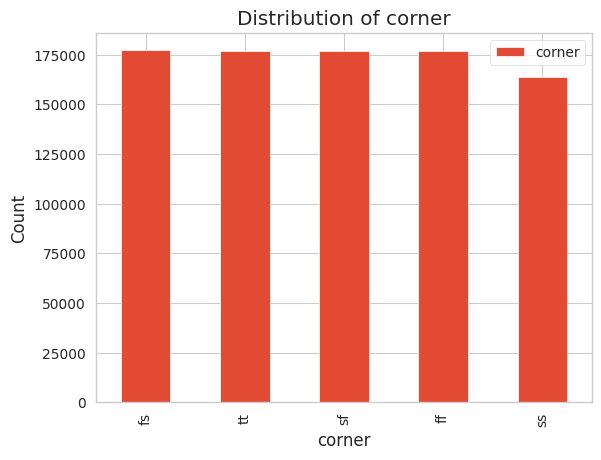

In [12]:
corner_counts = df['corner'].value_counts()

# Plot a bar chart
corner_counts.plot.bar()

# Add a title
plt.title('Distribution of corner')

# Add x and y labels
plt.xlabel('corner')
plt.ylabel('Count')

# Show the legend
plt.legend()

# Show the plot
plt.show()

## **Correlation matrix and heatmap**

In [13]:
numerical_features = []

for col in df.columns:
    if df[col].dtypes =='float64' or df[col].dtypes =='int64':
        numerical_features.append(col)

numerical_features

['vds',
 'L(um)',
 'W(um)',
 'drain_length(um)',
 'temperature',
 'vgs',
 'vsb',
 'id(uA)']

In [14]:
num_df=df[numerical_features]

In [15]:
df_dumm = pd.get_dummies(df,drop_first=True) # one hot encoding

In [16]:
df_dumm.shape

(871488, 12)

In [17]:
dataset_2 = df_dumm.drop(columns='id(uA)')

<Axes: title={'center': 'Correlated with current'}>

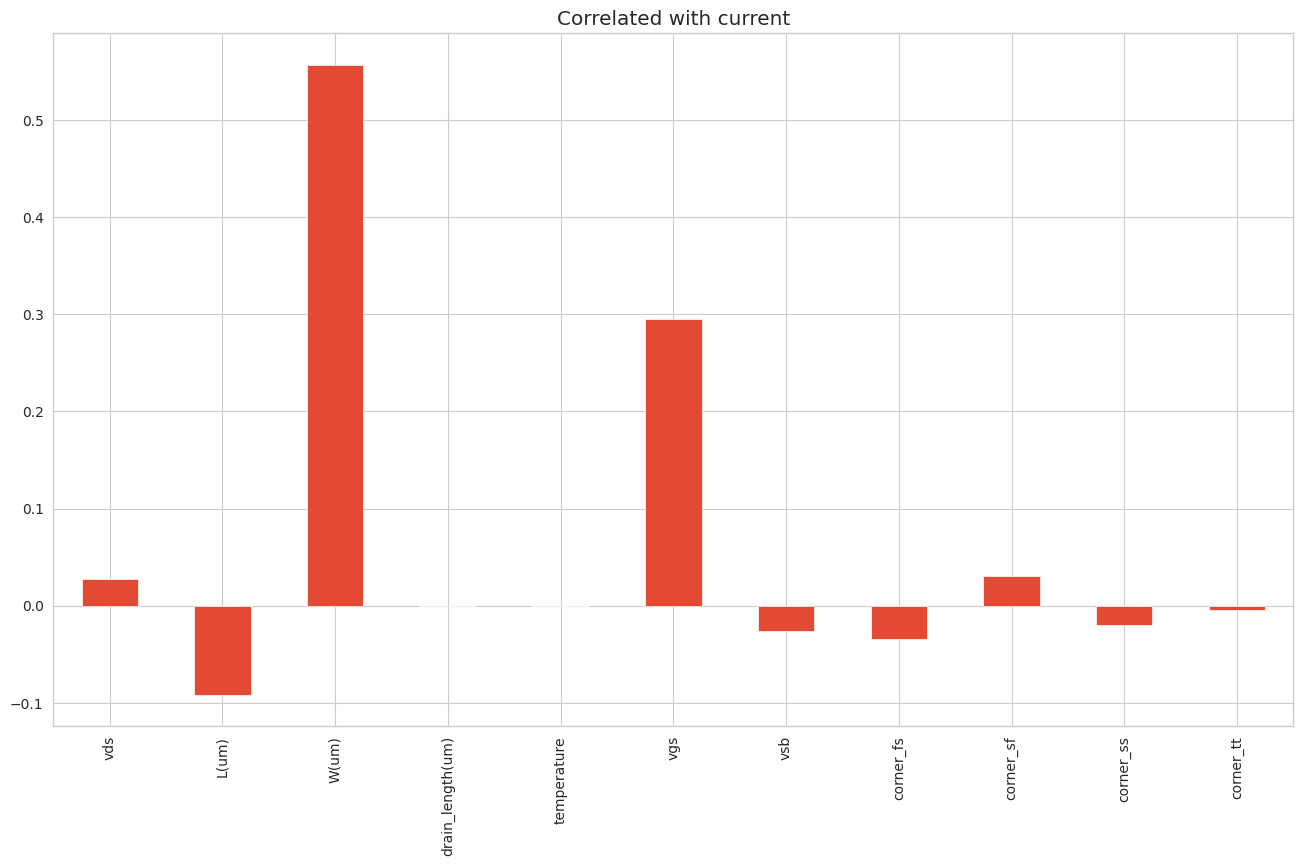

In [18]:
corr = dataset_2.corrwith(df_dumm['id(uA)'])
dataset_2.corrwith(df_dumm['id(uA)']).plot.bar(
    figsize=(16, 9),
    title='Correlated with current',
    grid=True
)

In [19]:
corr=num_df.corr()

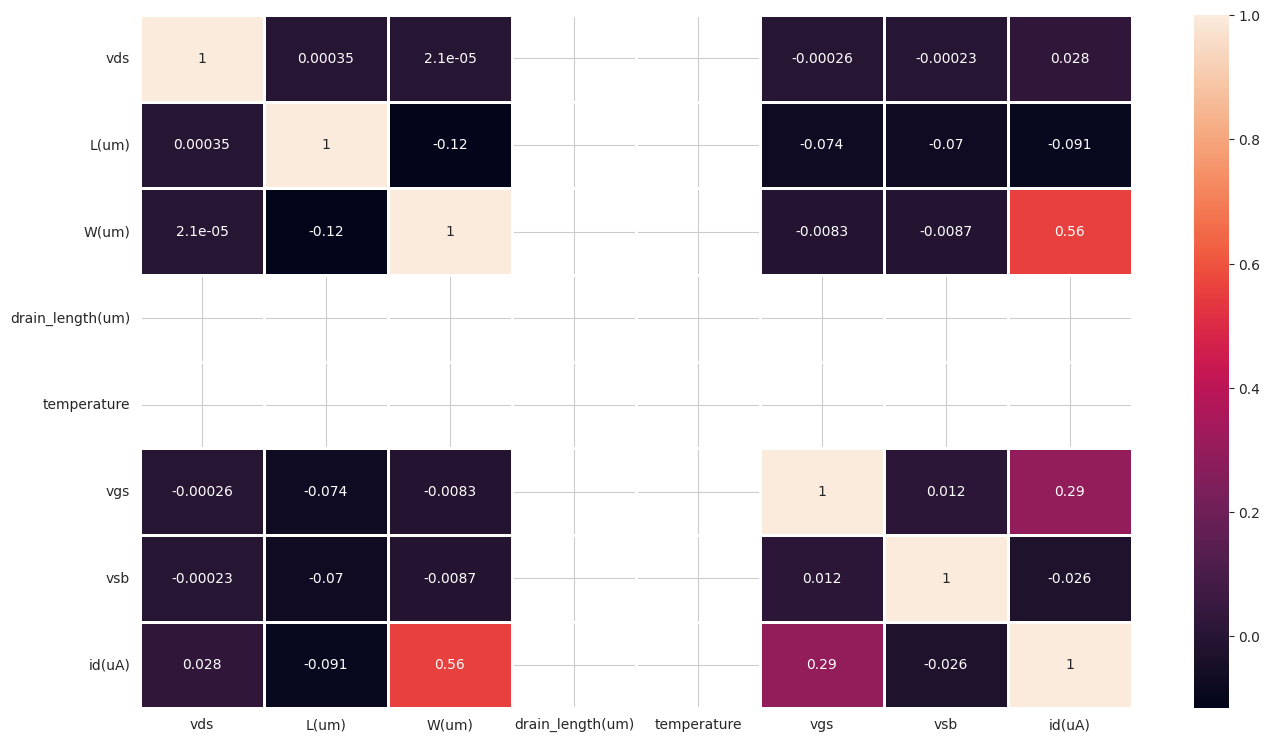

In [20]:
#correlation of numerical features
plt.figure(figsize=(16, 9))
ax = sns.heatmap(corr, annot=True, linewidths=2)

In [21]:
corr = df_dumm.corr()

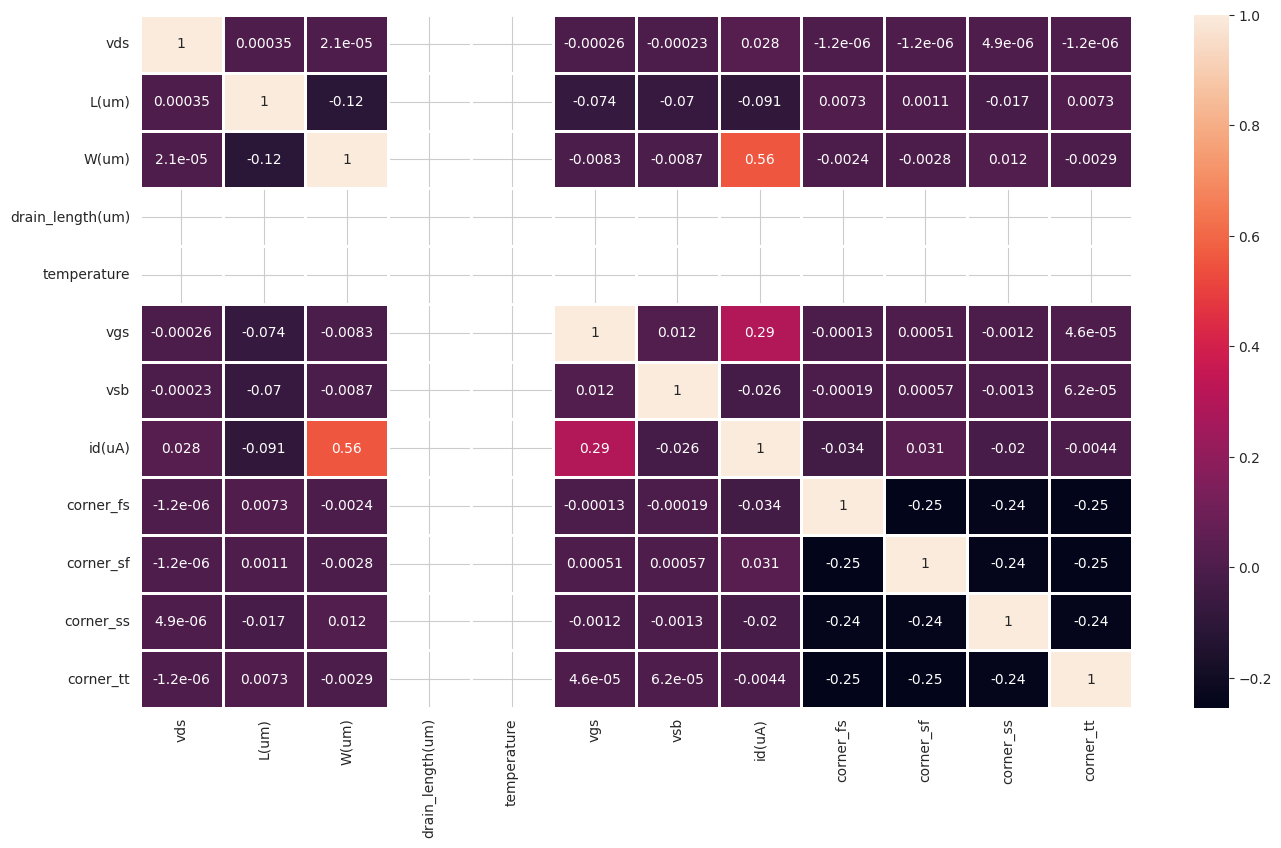

In [22]:
plt.figure(figsize=(16, 9))
ax = sns.heatmap(corr, annot=True, linewidths=2)

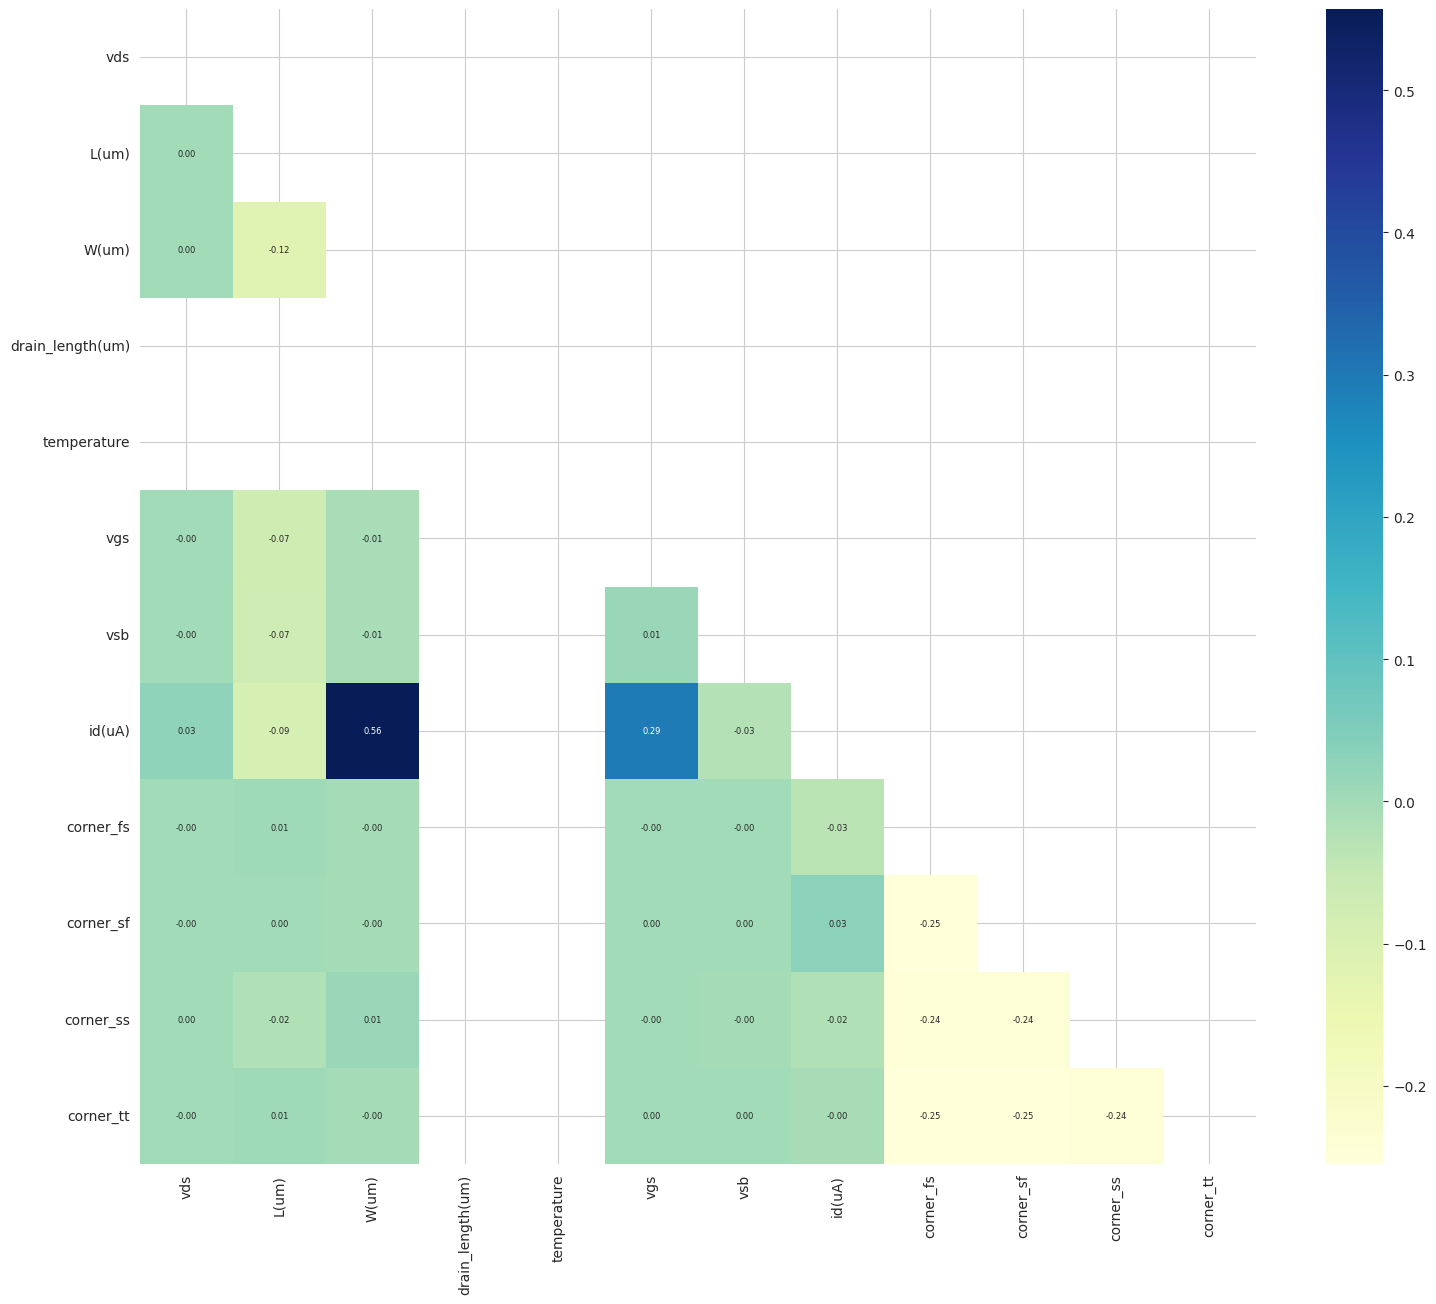

In [23]:
plt.figure(figsize=(18, 15))
mask = np.triu(np.ones_like(corr))
heatmap = sns.heatmap(corr, mask=mask, annot=True, cmap=plt.cm.YlGnBu, annot_kws={"fontsize": 6}, fmt=".2f")  # Set fmt to ".2f" to display 2 decimals
plt.show()

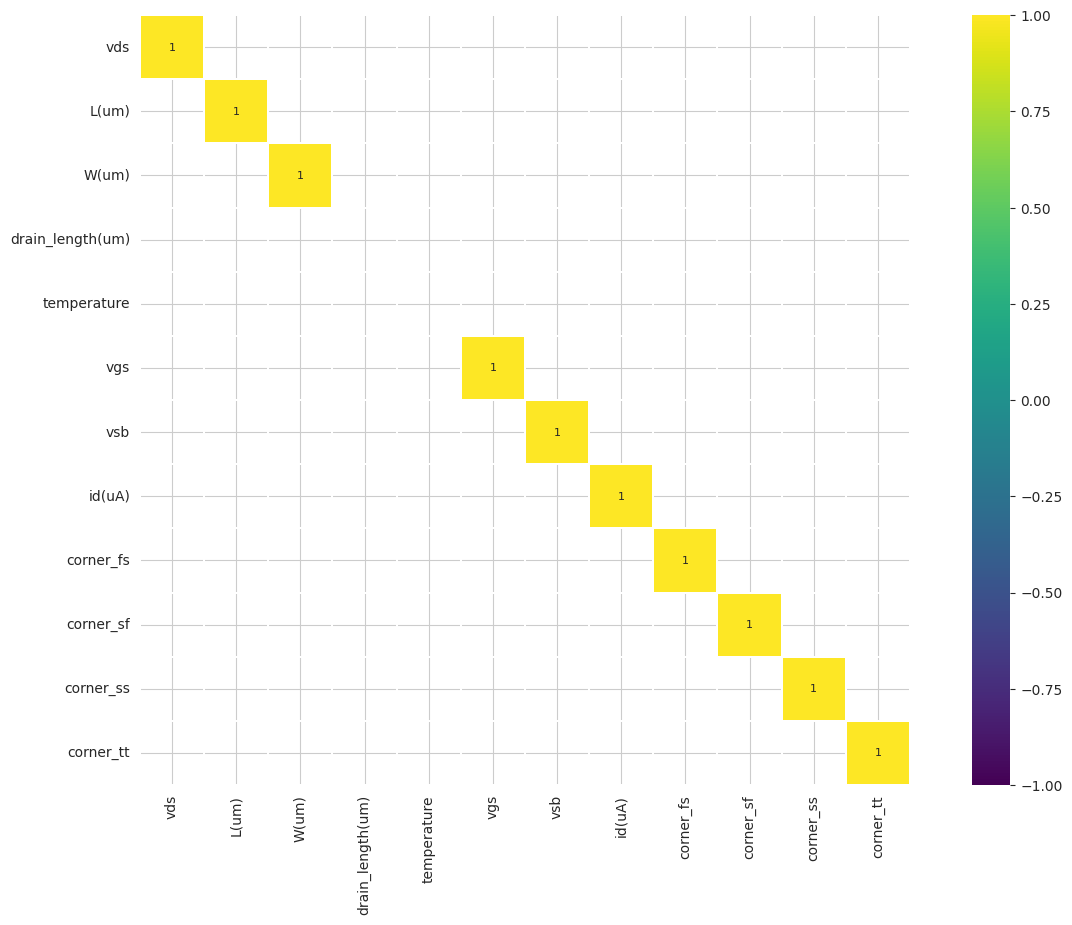

In [24]:
#check multicollinearity
plt.figure(figsize=(16, 10))

sns.heatmap(corr[(corr >= 0.8) | (corr <= -0.8)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

## **Numerical data distribution and Outliers**

For this part lets look at the distribution of all of the features by ploting them

To do so lets first list all the types of our data from our dataset and take only the numerical ones:

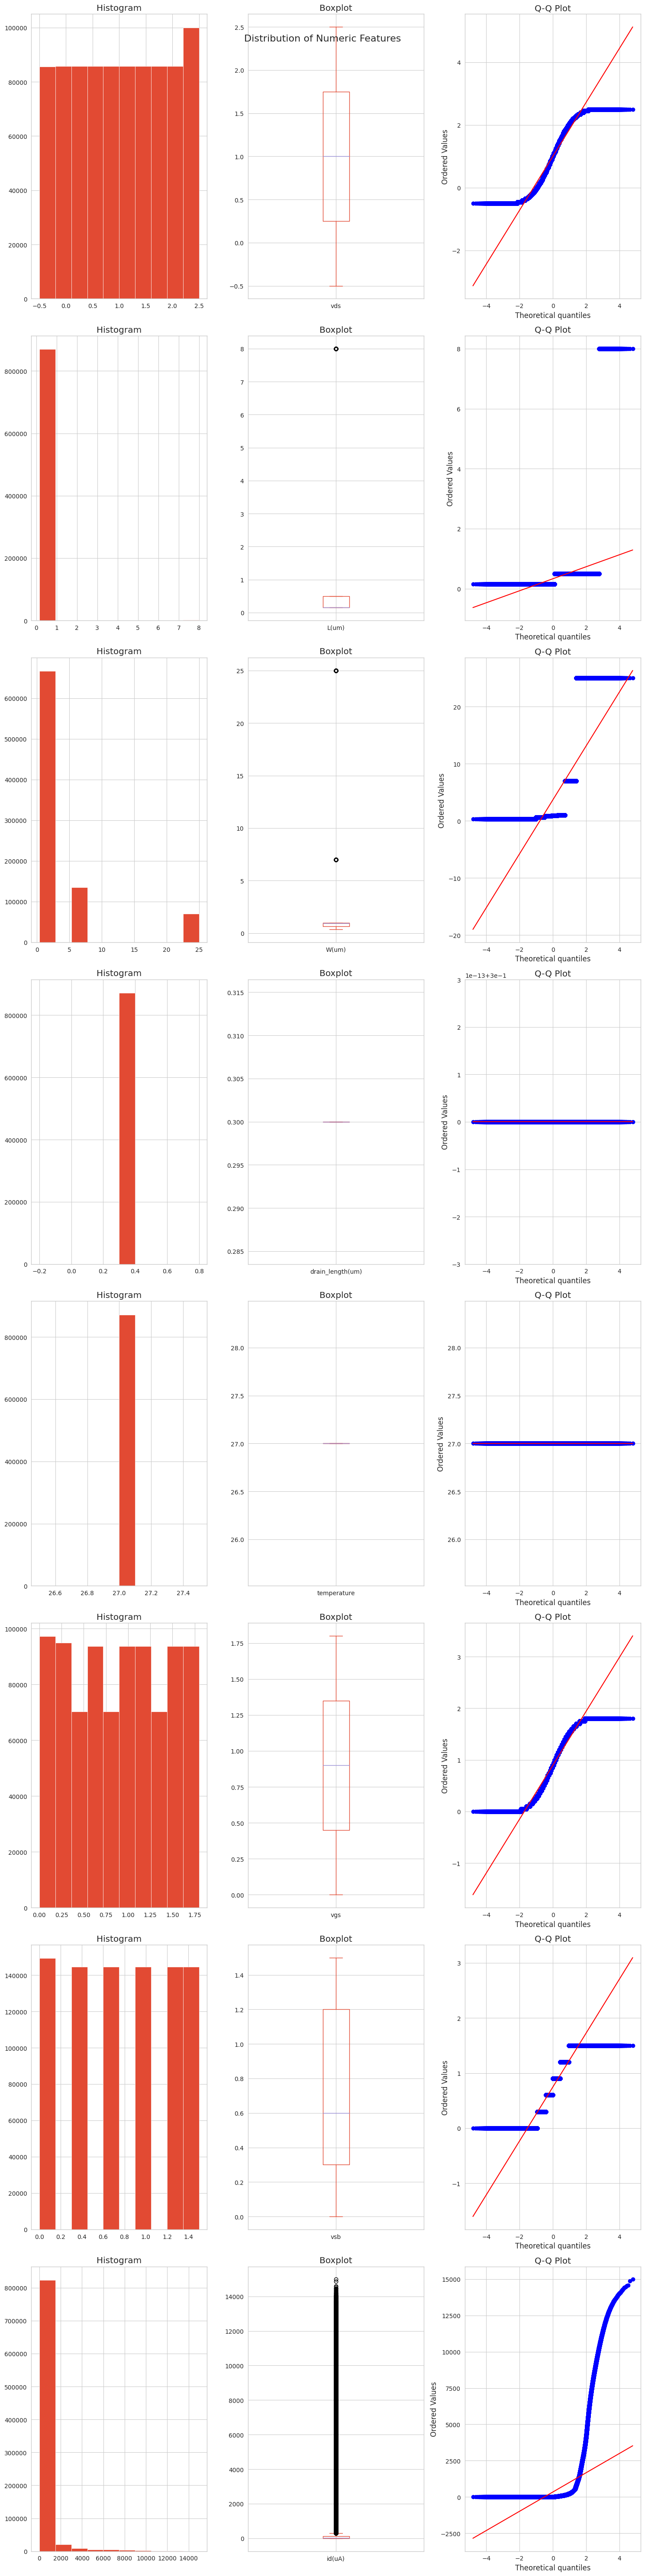

In [25]:
# Create figure and grid
fig, axes = plt.subplots(8, 3, figsize=(15,60))
fig.suptitle('Distribution of Numeric Features', fontsize=16)

# Loop through features
for i, col in enumerate(num_df.columns):

    # Histogram
    ax1 = axes[i, 0]
    num_df[col].hist(ax=ax1)
    ax1.set_title('Histogram')

    # Boxplot
    ax2 = axes[i, 1]
    num_df[col].plot(kind='box', ax=ax2)
    ax2.set_title('Boxplot')

    # Q-Q Plot
    ax3 = axes[i, 2]
    stats.probplot(num_df[col],
                  dist="norm",
                  plot=ax3)
    ax3.set_title('Q-Q Plot')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

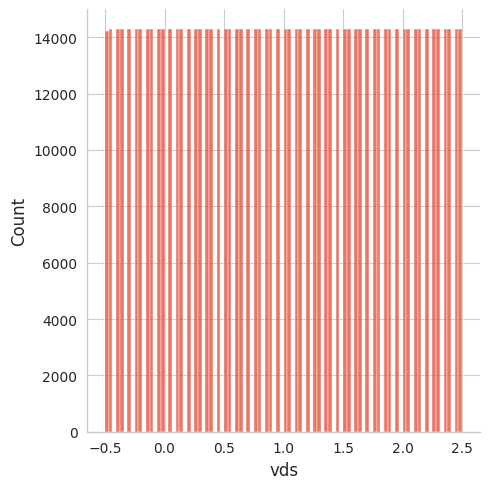

Column: vds
Skewness: -1.5058592061997834e-05
Kurtosis: -1.2006250858579952


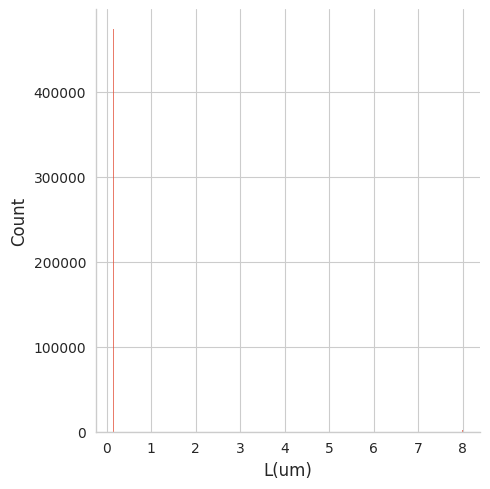

Column: L(um)
Skewness: 14.825409112051707
Kurtosis: 260.53188207325684


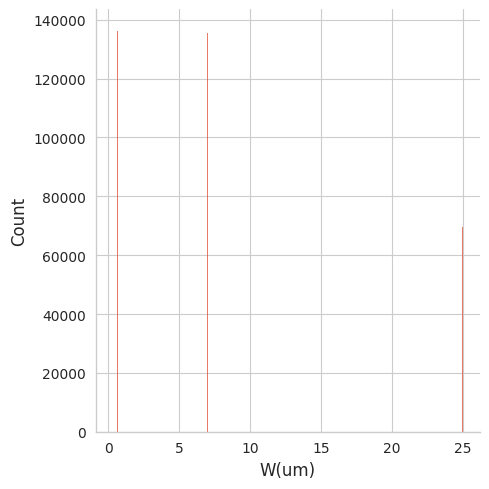

Column: W(um)
Skewness: 2.558237480628813
Kurtosis: 5.349661408513959


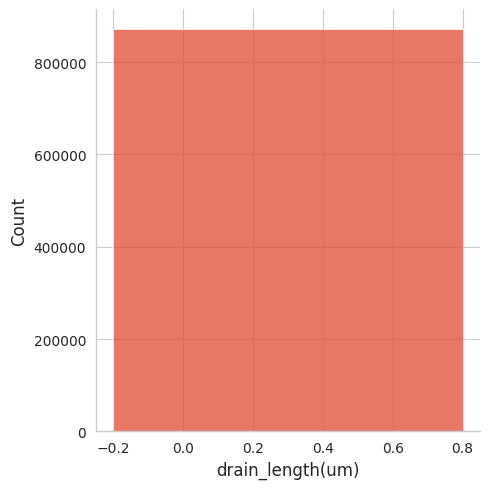

Column: drain_length(um)
Skewness: 0
Kurtosis: 0


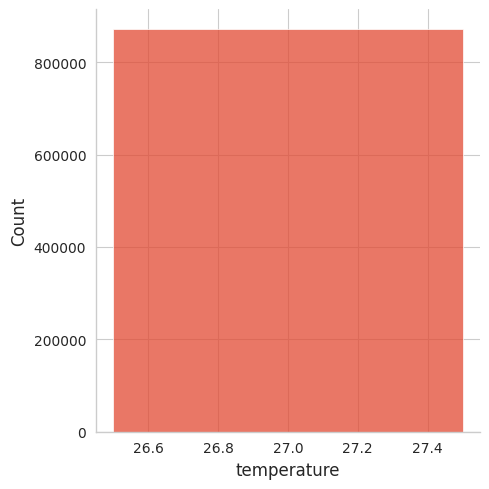

Column: temperature
Skewness: 0
Kurtosis: 0


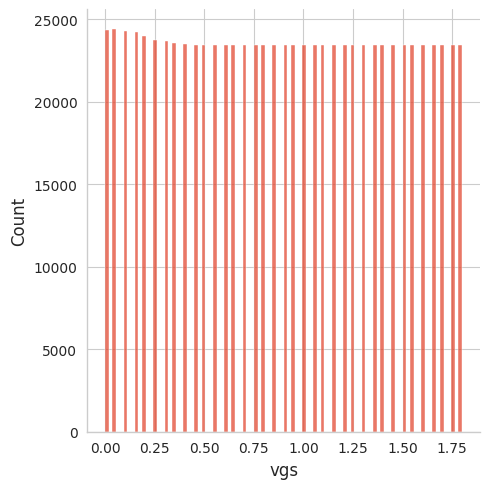

Column: vgs
Skewness: 0.006286010019730318
Kurtosis: -1.2074079757514553


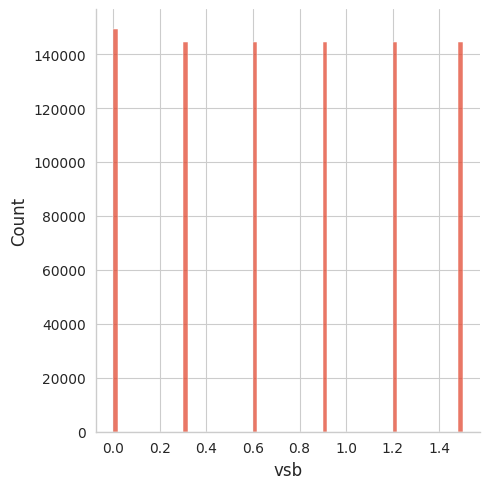

Column: vsb
Skewness: 0.006996558359132732
Kurtosis: -1.2745468503196478


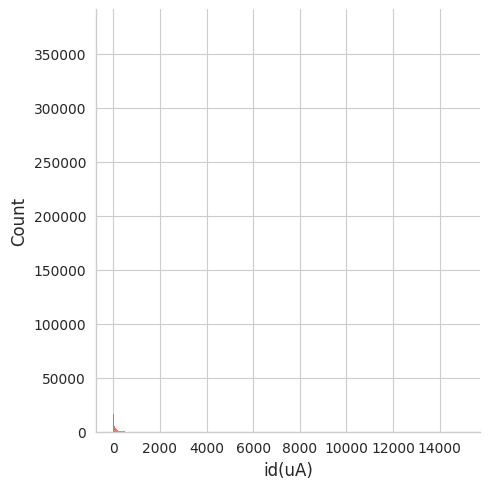

Column: id(uA)
Skewness: 5.878384130180467
Kurtosis: 39.36371758516644


In [26]:
for col in num_df.columns:

    # Plot histogram
    sns.displot(num_df[col], kind="hist")
    plt.show()

    # Check skewness
    skew = num_df[col].skew()

    # Check kurtosis
    kurt = num_df[col].kurt()

    print(f"Column: {col}")
    print(f"Skewness: {skew}")
    print(f"Kurtosis: {kurt}")

**Observations:**

- vds is approximately symmetric with little skewness and slightly lighter tails than normal.

- L(um) is highly right skewed with very heavy tails, indicating a long tail distribution.

- W(um) also shows some positive skewness but lesser than L. Kurtosis indicates heavier tails than normal.

- drain_length and temperature are constant with zero skewness and kurtosis as expected.

- vgs and vsb have small positive skews close to normal distribution.

- id(uA) is heavily right skewed with very heavy tails, showing a long tail distribution like L(um).

- Features with higher positive skews like L, W and id have their values concentrated on the left.

- Non-zero kurtosis values indicate features differ from normal distribution assumption.

- Skewed and heavy tailed features will need appropriate transformations for modeling.

**In summary, this reveals:**

while some features like vds may conform to normal assumptions, others like L, W and id have distinct non-normal distributions that need handling through power transforms, binning or other techniques for robust modeling and prediction.

# **Data Encoding**

In [6]:
df1 = pd.get_dummies(df,drop_first=True) # one hot encoding

In [7]:
df1

,vds,L(um),W(um),drain_length(um),temperature,vgs,vsb,id(uA),corner_fs,corner_sf,corner_ss,corner_tt
0,-0.45,8.00,0.84,0.3,27.0,0.0,0.0,0.034866,0,0,0,1
1,-0.40,8.00,0.84,0.3,27.0,0.0,0.0,0.009451,0,0,0,1
2,-0.35,8.00,0.84,0.3,27.0,0.0,0.0,0.002331,0,0,0,1
3,-0.30,8.00,0.84,0.3,27.0,0.0,0.0,0.000532,0,0,0,1
4,-0.25,8.00,0.84,0.3,27.0,0.0,0.0,0.000111,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
871483,2.30,0.15,7.00,0.3,27.0,1.8,1.5,4289.588350,0,0,0,0
871484,2.35,0.15,7.00,0.3,27.0,1.8,1.5,4326.932100,0,0,0,0
871485,2.40,0.15,7.00,0.3,27.0,1.8,1.5,4364.240650,0,0,0,0
871486,2.45,0.15,7.00,0.3,27.0,1.8,1.5,4401.516730,0,0,0,0


# **Baseline Model**

the network architecture: **Input -> Dense(128) -> Dense(64) -> Output**

It is a multi-layer perceptron (MLP) with 2 hidden layers of decreasing sizes to learn nonlinear relationships between the 11 input features and the single continuous output.

## **Data Scaling**

In [8]:
# Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df1)

# Convert to dataframe
scaled_df_t1 = pd.DataFrame(scaled_features,columns=df1.columns)
scaled_df_t1

,vds,L(um),W(um),drain_length(um),temperature,vgs,vsb,id(uA),corner_fs,corner_sf,corner_ss,corner_tt
0,0.016667,1.0,0.019481,0.0,0.0,0.0,0.0,2.327558e-06,0.0,0.0,0.0,1.0
1,0.033333,1.0,0.019481,0.0,0.0,0.0,0.0,6.309262e-07,0.0,0.0,0.0,1.0
2,0.050000,1.0,0.019481,0.0,0.0,0.0,0.0,1.556240e-07,0.0,0.0,0.0,1.0
3,0.066667,1.0,0.019481,0.0,0.0,0.0,0.0,3.548225e-08,0.0,0.0,0.0,1.0
4,0.083333,1.0,0.019481,0.0,0.0,0.0,0.0,7.423849e-09,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
871483,0.933333,0.0,0.269481,0.0,0.0,1.0,1.0,2.863596e-01,0.0,0.0,0.0,0.0
871484,0.950000,0.0,0.269481,0.0,0.0,1.0,1.0,2.888525e-01,0.0,0.0,0.0,0.0
871485,0.966667,0.0,0.269481,0.0,0.0,1.0,1.0,2.913431e-01,0.0,0.0,0.0,0.0
871486,0.983333,0.0,0.269481,0.0,0.0,1.0,1.0,2.938315e-01,0.0,0.0,0.0,0.0


In [9]:
X=scaled_df_t1[['vds', 'L(um)', 'W(um)', 'drain_length(um)', 'temperature', 'vgs', 'vsb','corner_fs',	'corner_sf',	'corner_ss',	'corner_tt']]
y= scaled_df_t1[['id(uA)']]

In [12]:
# Save scaler
pickle.dump(scaler, open('scaler.pkl','wb'))

## **Data Spliting**

In [13]:
X_train_t1, X_test_t1, y_train_t1, y_test_t1 = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Input features
inputs = keras.Input(shape=(11,))

# Hidden layers
x = keras.layers.Dense(128, activation='relu')(inputs)
x = keras.layers.Dense(64, activation='relu')(x)

# Output layer
outputs = keras.layers.Dense(1)(x)

# Create the model and name it 'model1'
model = keras.Model(inputs=inputs, outputs=outputs)

In [33]:
# Configure early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10)

# Train model with early stopping
model.compile(loss='mean_absolute_error', optimizer='adam')
history =model.fit(X_train_t1,
          y_train_t1,
          validation_split=0.2,
          epochs=100,
          callbacks=[es])

Epoch 1/100
17430/17430 [==============================] - 68s 4ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 2/100
17430/17430 [==============================] - 56s 3ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 3/100
17430/17430 [==============================] - 57s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/100
17430/17430 [==============================] - 58s 3ms/step - loss: 0.0011 - val_loss: 8.8647e-04
Epoch 5/100
17430/17430 [==============================] - 60s 3ms/step - loss: 0.0010 - val_loss: 8.8010e-04
Epoch 6/100
17430/17430 [==============================] - 58s 3ms/step - loss: 9.7141e-04 - val_loss: 9.3508e-04
Epoch 7/100
17430/17430 [==============================] - 61s 4ms/step - loss: 9.0595e-04 - val_loss: 7.3934e-04
Epoch 8/100
17430/17430 [==============================] - 63s 4ms/step - loss: 8.7545e-04 - val_loss: 8.2989e-04
Epoch 9/100
17430/17430 [==============================] - 63s 4ms/step - loss: 8.3873e-04 - val_loss: 7.9630e-04
Epoch 

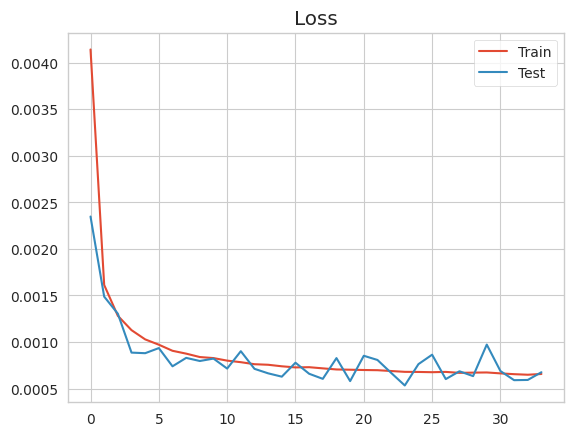

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['Train','Test'])
plt.show()

In [35]:
# Evaluate model on test data
model.evaluate(X_test_t1, y_test_t1)

5447/5447 [==============================] - 11s 2ms/step - loss: 6.8395e-04


0.0006839479901827872

**Observations:**

The model achieved a minimum training loss of 6.5698e-04. This shows it was able to learn patterns in the training data effectively.

The validation loss was slightly higher at 6.7582e-04. This small difference indicates the model was not overfitting the training data.

# **Trial 1**

## **Data Scaling**

some suggestions for scaling of the features (L, W, id):

- L (channel length): Scale to μm since this is the base unit provided. No scaling needed.

- W (channel width): Also scale to μm for consistency with L. No scaling needed.

- id (drain current): Typically id is measured in μA (microamps), but the values could vary widely depending on transistor size/conditions.

A common scaling would be:
  - Standardize/normalize: Subtract mean and divide by standard deviation to rescale features to have mean 0 and standard deviation 1.
  - Log transform: Take log(id) to compress higher values since current increases rapidly with size. Many physical processes exhibit logarithmic behavior.

In [36]:
# Create a copy of original dataframe to keep original unchanged
scaled_df_t2 = df1.copy()

In [37]:
# MinMax scale L and W
scaled_features = scaler.fit_transform(scaled_df_t2)

# Convert to dataframe
scaled_df_t2 = pd.DataFrame(scaled_features,columns=scaled_df_t2.columns)
scaled_df_t2

,vds,L(um),W(um),drain_length(um),temperature,vgs,vsb,id(uA),corner_fs,corner_sf,corner_ss,corner_tt
0,0.016667,1.0,0.019481,0.0,0.0,0.0,0.0,2.327558e-06,0.0,0.0,0.0,1.0
1,0.033333,1.0,0.019481,0.0,0.0,0.0,0.0,6.309262e-07,0.0,0.0,0.0,1.0
2,0.050000,1.0,0.019481,0.0,0.0,0.0,0.0,1.556240e-07,0.0,0.0,0.0,1.0
3,0.066667,1.0,0.019481,0.0,0.0,0.0,0.0,3.548225e-08,0.0,0.0,0.0,1.0
4,0.083333,1.0,0.019481,0.0,0.0,0.0,0.0,7.423849e-09,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
871483,0.933333,0.0,0.269481,0.0,0.0,1.0,1.0,2.863596e-01,0.0,0.0,0.0,0.0
871484,0.950000,0.0,0.269481,0.0,0.0,1.0,1.0,2.888525e-01,0.0,0.0,0.0,0.0
871485,0.966667,0.0,0.269481,0.0,0.0,1.0,1.0,2.913431e-01,0.0,0.0,0.0,0.0
871486,0.983333,0.0,0.269481,0.0,0.0,1.0,1.0,2.938315e-01,0.0,0.0,0.0,0.0


In [38]:
# Take log transformation of 'id(uA)' column
scaled_df_t2['id(uA)_log'] = np.log(df1['id(uA)'])

In [39]:
scaled_df_t2

,vds,L(um),W(um),drain_length(um),temperature,vgs,vsb,id(uA),corner_fs,corner_sf,corner_ss,corner_tt,id(uA)_log
0,0.016667,1.0,0.019481,0.0,0.0,0.0,0.0,2.327558e-06,0.0,0.0,0.0,1.0,-3.356238
1,0.033333,1.0,0.019481,0.0,0.0,0.0,0.0,6.309262e-07,0.0,0.0,0.0,1.0,-4.661624
2,0.050000,1.0,0.019481,0.0,0.0,0.0,0.0,1.556240e-07,0.0,0.0,0.0,1.0,-6.061370
3,0.066667,1.0,0.019481,0.0,0.0,0.0,0.0,3.548225e-08,0.0,0.0,0.0,1.0,-7.539780
4,0.083333,1.0,0.019481,0.0,0.0,0.0,0.0,7.423849e-09,0.0,0.0,0.0,1.0,-9.104115
...,...,...,...,...,...,...,...,...,...,...,...,...,...
871483,0.933333,0.0,0.269481,0.0,0.0,1.0,1.0,2.863596e-01,0.0,0.0,0.0,0.0,8.363946
871484,0.950000,0.0,0.269481,0.0,0.0,1.0,1.0,2.888525e-01,0.0,0.0,0.0,0.0,8.372614
871485,0.966667,0.0,0.269481,0.0,0.0,1.0,1.0,2.913431e-01,0.0,0.0,0.0,0.0,8.381199
871486,0.983333,0.0,0.269481,0.0,0.0,1.0,1.0,2.938315e-01,0.0,0.0,0.0,0.0,8.389704


In [40]:
X=scaled_df_t2[['vds', 'L(um)', 'W(um)', 'drain_length(um)', 'temperature', 'vgs', 'vsb','corner_fs',	'corner_sf',	'corner_ss',	'corner_tt']]
y= scaled_df_t2[['id(uA)_log']]

## **Data Spliting**

In [41]:
X_train_t2, X_test_t2, y_train_t2, y_test_t2 = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Input features
inputs = keras.Input(shape=(11,))

# Hidden layers
x = keras.layers.Dense(512, activation='relu')(inputs)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)

# Output layer
outputs = keras.layers.Dense(1)(x)

# Create the model and name it 'model2'
model1 = keras.Model(inputs=inputs, outputs=outputs)

In [43]:
# Configure early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10)

# Train model with early stopping
model1.compile(loss='mean_absolute_error', optimizer='adam')
history1 = model1.fit(X_train_t2,
          y_train_t2,
          validation_split=0.2,
          epochs=100,
          callbacks=[es])

Epoch 1/100
17430/17430 [==============================] - 66s 4ms/step - loss: inf - val_loss: inf
Epoch 2/100
17430/17430 [==============================] - 62s 4ms/step - loss: inf - val_loss: inf
Epoch 3/100
17430/17430 [==============================] - 62s 4ms/step - loss: inf - val_loss: inf
Epoch 4/100
17430/17430 [==============================] - 66s 4ms/step - loss: inf - val_loss: inf
Epoch 5/100
17430/17430 [==============================] - 65s 4ms/step - loss: inf - val_loss: inf
Epoch 6/100
17430/17430 [==============================] - 62s 4ms/step - loss: inf - val_loss: inf
Epoch 7/100
17430/17430 [==============================] - 61s 4ms/step - loss: inf - val_loss: inf
Epoch 8/100
17430/17430 [==============================] - 63s 4ms/step - loss: inf - val_loss: inf
Epoch 9/100
17430/17430 [==============================] - 62s 4ms/step - loss: inf - val_loss: inf
Epoch 10/100
17430/17430 [==============================] - 61s 4ms/step - loss: inf - val_loss: inf

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss')
plt.legend(['Train','Test'])
plt.show()

In [ ]:
# Evaluate model on test data
model1.evaluate(X_test_t2, y_test_t2)

**Observations:**

the loss reported for both training and validation sets remained at "inf" (infinity) for all epochs.

This indicates the model was unable to converge on a solution and minimize the loss even after 10 epochs of training.

The losses did not decrease at all from their initial value.

This trial showed that for this particular prediction task, it is best to avoid applying a log transformation to the target current values during training.

# **Trial 2**

the network architecture: **Input -> Dense(512) -> Dense(128) -> Dense(64) -> Output**

It is a multi-layer perceptron (MLP) with 3 hidden layers of decreasing sizes to learn nonlinear relationships between the 11 input features and the single continuous output.

In [ ]:
# Input features
inputs = keras.Input(shape=(11,))

# Hidden layers
x = keras.layers.Dense(512, activation='relu')(inputs)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)

# Output layer
outputs = keras.layers.Dense(1)(x)

# Create the model and name it 'model1'
model2 = keras.Model(inputs=inputs, outputs=outputs)

In [47]:
# Configure early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10)

# Train model with early stopping
model2.compile(loss='mean_absolute_error', optimizer='adam')
history2 =model2.fit(X_train_t1,
          y_train_t1,
          validation_split=0.2,
          epochs=100,
          callbacks=[es])

Epoch 1/100
17430/17430 [==============================] - 68s 4ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 2/100
17430/17430 [==============================] - 68s 4ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/100
17430/17430 [==============================] - 67s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/100
17430/17430 [==============================] - 66s 4ms/step - loss: 9.8479e-04 - val_loss: 7.2098e-04
Epoch 5/100
17430/17430 [==============================] - 61s 3ms/step - loss: 9.2351e-04 - val_loss: 7.9427e-04
Epoch 6/100
17430/17430 [==============================] - 60s 3ms/step - loss: 8.6349e-04 - val_loss: 6.5068e-04
Epoch 7/100
17430/17430 [==============================] - 62s 4ms/step - loss: 8.0352e-04 - val_loss: 8.8587e-04
Epoch 8/100
17430/17430 [==============================] - 59s 3ms/step - loss: 7.7004e-04 - val_loss: 7.1784e-04
Epoch 9/100
17430/17430 [==============================] - 59s 3ms/step - loss: 7.5680e-04 - val_loss: 0.0011
Ep

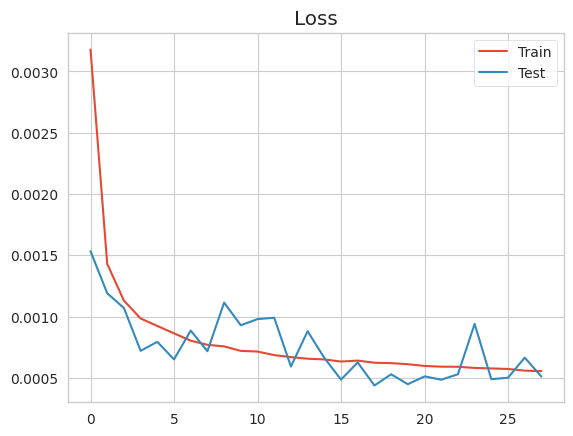

In [48]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss')
plt.legend(['Train','Test'])
plt.show()

In [49]:
# Evaluate model on test data
evaluation_results = model2.evaluate(X_test_t1, y_test_t1)

5447/5447 [==============================] - 11s 2ms/step - loss: 5.1351e-04


**Observations:**

All reported losses are extremely low, below 0.000055.

The small difference between validation and test losses indicates the model has learned the underlying patterns rather than just memorizing the training data.

# **Trial 3**

This architecture incorporates dropout layers to prevent overfitting by randomly dropping 20% of the neurons during training. Additionally, layer normalization is applied after each dense layer to help stabilize the training process and improve convergence. The early stopping callback is used to prevent overfitting and save time during training by stopping when the validation loss plateaus.


In [14]:
# Input features
inputs = keras.Input(shape=(11,))

# Hidden layers
x = keras.layers.Dense(512, activation='relu')(inputs)
x = Dropout(0.2)(x)  # Add a dropout layer with a dropout rate of 0.2
x = LayerNormalization()(x)  # Add a layer normalization layer
x = keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)  # Add a dropout layer with a dropout rate of 0.2
x = LayerNormalization()(x)  # Add a layer normalization layer
x = keras.layers.Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)  # Add a dropout layer with a dropout rate of 0.2
x = LayerNormalization()(x)  # Add a layer normalization layer

# Output layer
outputs = keras.layers.Dense(1)(x)

# Create the model and name it 'model3'
model3 = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
# Configure early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10)

# Train model with early stopping
model3.compile(loss='mean_absolute_error', optimizer='adam')
history3 = model3.fit(X_train_t1,
          y_train_t1,
          validation_split=0.2,
          epochs=100,
          callbacks=[es])

Epoch 1/100
17430/17430 [==============================] - 83s 5ms/step - loss: 0.0121 - val_loss: 0.0055
Epoch 2/100
17430/17430 [==============================] - 76s 4ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 3/100
17430/17430 [==============================] - 81s 5ms/step - loss: 0.0051 - val_loss: 0.0062
Epoch 4/100
17430/17430 [==============================] - 79s 5ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 5/100
17430/17430 [==============================] - 80s 5ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 6/100
17430/17430 [==============================] - 80s 5ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 7/100
17430/17430 [==============================] - 76s 4ms/step - loss: 0.0036 - val_loss: 0.0046
Epoch 8/100
17430/17430 [==============================] - 79s 5ms/step - loss: 0.0035 - val_loss: 0.0044
Epoch 9/100
17430/17430 [==============================] - 76s 4ms/step - loss: 0.0034 - val_loss: 0.0045
Epoch 10/100
17430/17430 [====================

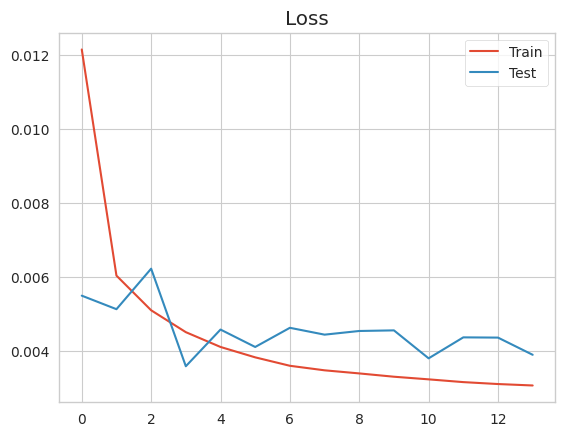

In [16]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss')
plt.legend(['Train','Test'])
plt.show()

In [17]:
# Evaluate model on test data
evaluation_results = model3.evaluate(X_test_t1, y_test_t1)

5447/5447 [==============================] - 10s 2ms/step - loss: 0.0040


In [20]:
# Save the model
model3.save('model.h5')

**Observations:**

all the losses - training, validation and test are very close with minor variations. This indicates the model fits the data distribution well without overfitting and can generalize to make robust predictions on new examples. The low average losses also demonstrate that the model is able to learn the underlying patterns in the data with high accuracy.
